In [1]:
from os import chdir; chdir('../')
import matplotlib.pyplot as plt
import seaborn
from lib.app import Q
from lib.helpers.database_helper import pull_actions
from lib.helpers.database_helper import pull_and_shape_batch
from lib.helpers.database_helper import pull_training_and_test_sets
from lib.helpers.pipeline_helper import initialize_training_session
from lib.helpers.pipeline_helper import prepare_plot_vectors
from lib.helpers.pipeline_helper import train_via_random_search
from lib.helpers.redis_helper import get_best_loss, get_weights_matrix, set_best_loss, set_weights_matrix
from lib.helpers.redis_helper import get_training_count, init_training_count
from lib.nn.metrics import measure_accuracy, measure_f1_score, correlation_matrix
from lib.nn.functions import predict, random_matrix

It is of note that we will be doing the training via distributed processing. As such, we can not store the `best_loss` and `weights_matrix` in memory. Instead, we store the values in Redis. We have written a few methods to handle the storage and retrie    val of these values.

- `read_best_loss`
- `read_weights_matrix`
- `write_best_loss`
- `write_weights_matrix`

In [2]:
training_set, test_set = pull_training_and_test_sets(limit=700000,split=.99)

In [3]:
features, outcomes = pull_and_shape_batch(action_ids=test_set)

## Random Search

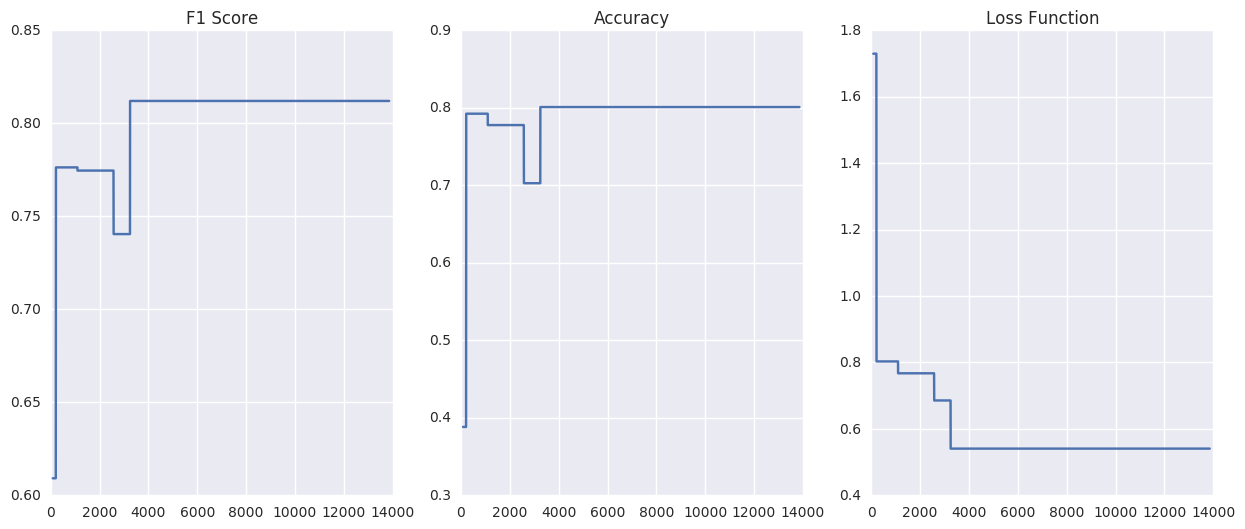

In [4]:
initialize_training_session()
batch_size = 50
for i in range(int(len(training_set)/batch_size)):
    Q.enqueue(train_via_random_search,
              action_ids=training_set[i*batch_size:(i+1)*batch_size],
              gamma=0.001)
counts, f_1_scores, \
    accuracies, \
    loss_values = prepare_plot_vectors(features, 
                                       outcomes, 
                                       length=int(len(training_set)/batch_size))    
    
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title('F1 Score')
plt.plot(counts[1:], f_1_scores[1:])
plt.subplot(1,3,2)
plt.title('Accuracy')
plt.plot(counts[1:], accuracies[1:])
plt.subplot(133)
plt.title('Loss Function')
plt.plot(counts[1:], loss_values[1:])    